### DLDS Project: Student Depression

Group Members: Vincent Beyer, Sehee Park, Christsanctus Maria Prasasta Surya

**Research questions:**
1. What factors correlate the most with depression in students?
2. Do depressed students have higher academic pressure?

Dataset - Student Depression Dataset:
https://www.kaggle.com/datasets/adilshamim8/student-depression-dataset/data

**Dataset description (from Kaggle)**

"This dataset was compiled from multiple sources to provide a comprehensive view of mental health trends among students. The data was originally gathered through anonymized, self-reported surveys distributed across various educational institutions. Participants provided information on demographics, academic performance, lifestyle habits, and mental health indicators using standardized instruments and depression scales.

Prior to integration, the data underwent several key transformations:

Data Cleaning: Inconsistent entries and missing values were identified and handled to ensure data quality.

Anonymization: Sensitive information was removed or encoded to protect individual privacy, ensuring compliance with ethical research standards.

Normalization: Numerical values and categorical responses were standardized to facilitate comparative analysis and robust modeling.

Feature Selection: Redundant or non-essential variables were pruned to streamline analysis and enhance the dataset's usability."

Based on the names of the cities the data was collected from Indian students.

# Imports

In [ ]:
import gdown

file_id = '15HoMRotORzYPJdzG5g8AWxBhWUVG-BkX'
url = f'https://drive.google.com/uc?id={file_id}'

output = 'student_depression_dataset.csv'
gdown.download(url, output, fuzzy=True, quiet=False)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import math
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats
from scipy.stats import norm
from scipy.stats import levene
from scipy.stats import mannwhitneyu

Downloading...
From: https://drive.google.com/uc?id=15HoMRotORzYPJdzG5g8AWxBhWUVG-BkX
To: /content/student_depression_dataset.csv
100%|██████████| 2.90M/2.90M [00:00<00:00, 23.2MB/s]


# Cleaning the data

In [ ]:
df = pd.read_csv("student_depression_dataset.csv")

df.drop(columns=['id','Work Pressure', 'Job Satisfaction', 'Profession', 'Dietary Habits'],inplace=True)

df.rename(columns={"Work/Study Hours": "study_hours",
                   "Academic Pressure": "academic_pressure",
                   "Financial Stress": "financial_stress",
                   "Study Satisfaction": "study_satisfaction",
                   "Sleep Duration": "sleep_duration",
                   "Have you ever had suicidal thoughts ?": "suicidal_thoughts",
                   "Family History of Mental Illness": "family_history"},
          inplace=True)

df.columns = df.columns.str.lower()

df["financial_stress"] = pd.to_numeric(df["financial_stress"], errors="coerce")
#print(np.sum(df.isna()))
df.dropna(inplace=True)
#df.drop(df[df["academic_pressure"]==0].index, inplace=True)
df.reset_index(drop=True, inplace=True)

df["suicidal_thoughts"] = df["suicidal_thoughts"].replace({"Yes": 1, "No": 0})
df["family_history"]    = df["family_history"].replace({"Yes": 1, "No": 0})

# df_numeric = df.select_dtypes(include=["int64", "float64"])
# df_categorical = df.select_dtypes(exclude=["int64", "float64"])

/tmp/ipython-input-2-276685476.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["suicidal_thoughts"] = df["suicidal_thoughts"].replace({"Yes": 1, "No": 0})
/tmp/ipython-input-2-276685476.py:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["family_history"]    = df["family_history"].replace({"Yes": 1, "No": 0})


In [ ]:
# print(df.dtypes)
# for col in df.columns:
#     print(df[col].value_counts())

In [ ]:
df.head()

,gender,age,city,academic_pressure,cgpa,study_satisfaction,sleep_duration,degree,suicidal_thoughts,study_hours,financial_stress,family_history,depression
0,Male,33.0,Visakhapatnam,5.0,8.97,2.0,'5-6 hours',B.Pharm,1,3.0,1.0,0,1
1,Female,24.0,Bangalore,2.0,5.90,5.0,'5-6 hours',BSc,0,3.0,2.0,1,0
2,Male,31.0,Srinagar,3.0,7.03,5.0,'Less than 5 hours',BA,0,9.0,1.0,1,0
3,Female,28.0,Varanasi,3.0,5.59,2.0,'7-8 hours',BCA,1,4.0,5.0,1,1
4,Female,25.0,Jaipur,4.0,8.13,3.0,'5-6 hours',M.Tech,1,1.0,1.0,0,0


**The reasons for dropping columns "Work Pressure", "Job Satisfaction", "Profession"**

We drop 'Work Pressure' and 'Job Satisfaction' becasue all values in these columns are 0. (Likely because of prior filtering)
That means that the students we will be analysing either don't work a job or report a work pressure and job satisfaction of 0.

We drop 'Profession' because almost all students don't specify a profession other than 'Student'.

**Selected Column descriptions:**

Academic Pressure:
"A measure indicating the level of pressure the student faces in academic settings. This could include stress from exams, assignments, and overall academic expectations."

CGPA:
"The cumulative grade point average of the student, reflecting overall academic performance."

Study Satisfaction:
"An indicator of how satisfied the student is with their studies, which can correlate with mental well-being."

Sleep Duration:
"The average number of hours the student sleeps per day, which is an important factor in mental health."

Degree:
"The academic degree or program that the student is pursuing."

Suicidal Thoughts:
"A binary indicator (Yes/No) that reflects whether the student has ever experienced suicidal ideation."

Study Hours:
"The average number of hours per day the student dedicates to study, which can influence stress levels."

Financial Stress:
"A measure of the stress experienced due to financial concerns, which may affect mental health."

Family History:
"Indicates whether there is a family history of mental illness (Yes/No), which can be a significant factor in mental health predispositions."

Depression:
"Indicates whether the student is experiencing depression (Yes/No)."



# Plotting the dataset

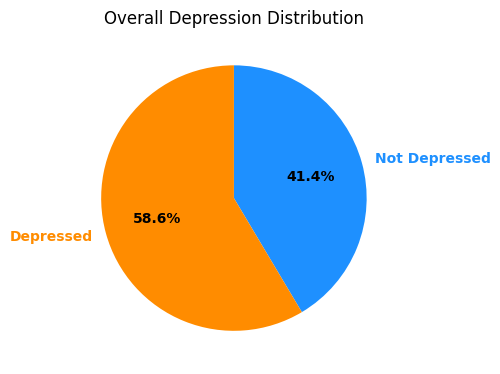

In [ ]:

counts = df["depression"].value_counts()
labels = ["Not Depressed", "Depressed"]
sizes  = [counts[0], counts[1]]

colors = ["dodgerblue", "darkorange"]
fig, ax = plt.subplots(figsize=(5, 5))

wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct="%1.1f%%",
    startangle=90, counterclock=False
)

for i, txt in enumerate(texts):
    txt.set_color(colors[i])
    txt.set_fontweight("bold")

for aut in autotexts:
    aut.set_fontweight("bold")

ax.set_title("Overall Depression Distribution")
plt.tight_layout()
plt.show()


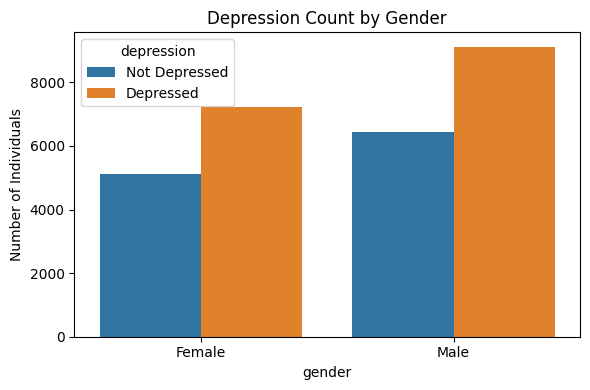

In [ ]:
gender_depression = df.copy()
gender_depression = gender_depression[["gender", "depression"]]
gender_depression = gender_depression.groupby(["gender", "depression"]).size().reset_index(name="count")
gender_depression["depression"] = gender_depression["depression"].map({0: "Not Depressed", 1: "Depressed"})

plt.figure(figsize=(6, 4))
sns.barplot(data=gender_depression, x="gender", y="count", hue="depression")
plt.title("Depression Count by Gender")
plt.ylabel("Number of Individuals")
plt.tight_layout()
plt.show()


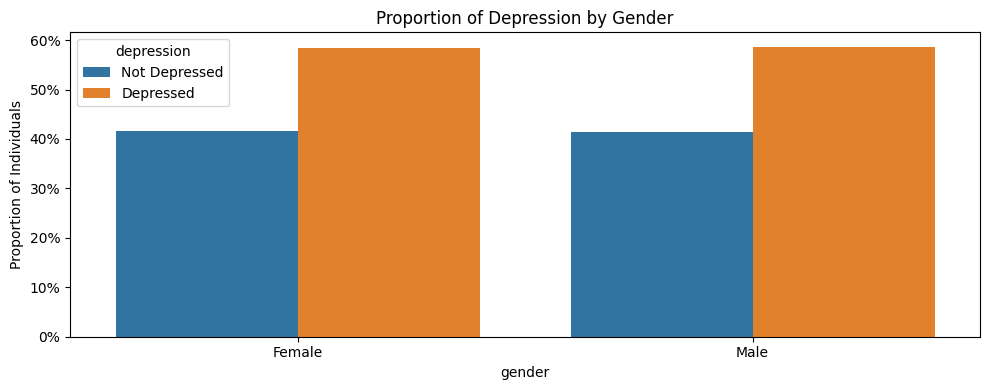

In [ ]:
gender_prop = df[["gender", "depression"]].copy()

gender_prop = (
    gender_prop.groupby(["gender", "depression"])
               .size()
               .reset_index(name="count")
)

gender_prop["total"] = (
    gender_prop.groupby("gender")["count"]
               .transform("sum")
)

gender_prop["prop"] = gender_prop["count"] / gender_prop["total"]

gender_prop["depression"] = gender_prop["depression"].map(
    {0: "Not Depressed", 1: "Depressed"}
)

plt.figure(figsize=(10, 4))
sns.barplot(data=gender_prop, x="gender", y="prop", hue="depression")
plt.gca().yaxis.set_major_formatter(
    plt.FuncFormatter(lambda y, _: f"{y:.0%}")
)
plt.title("Proportion of Depression by Gender")
plt.ylabel("Proportion of Individuals")
plt.tight_layout()
plt.show()

There is almost no difference between genders.

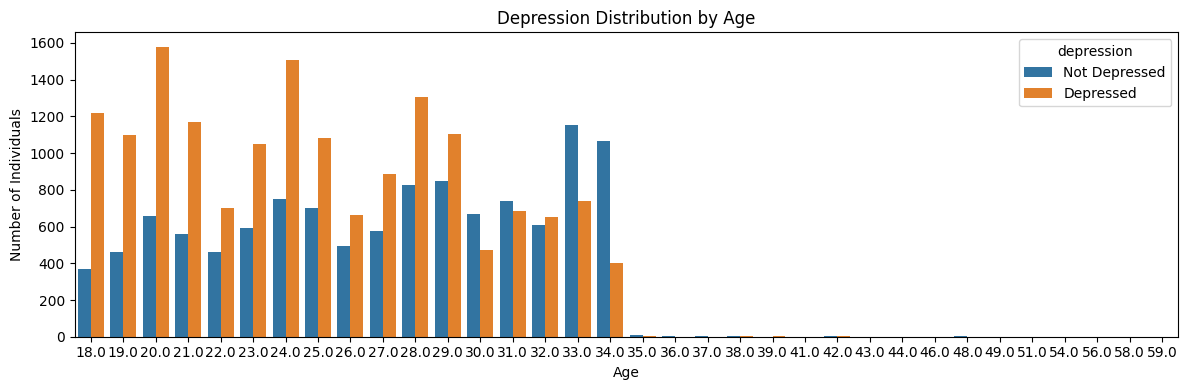

In [ ]:
age_depression = df.copy()
age_depression = age_depression[["age", "depression"]]
age_depression = age_depression.groupby(["age", "depression"]).size().reset_index(name="count")
age_depression["depression"] = age_depression["depression"].map({0: "Not Depressed", 1: "Depressed"})


plt.figure(figsize=(12, 4))
sns.barplot(data=age_depression, x="age", y="count", hue="depression")
plt.title("Depression Distribution by Age")
plt.xlabel("Age")
plt.ylabel("Number of Individuals")
plt.tight_layout()
plt.show()

There are more young students who are depressed than older students.

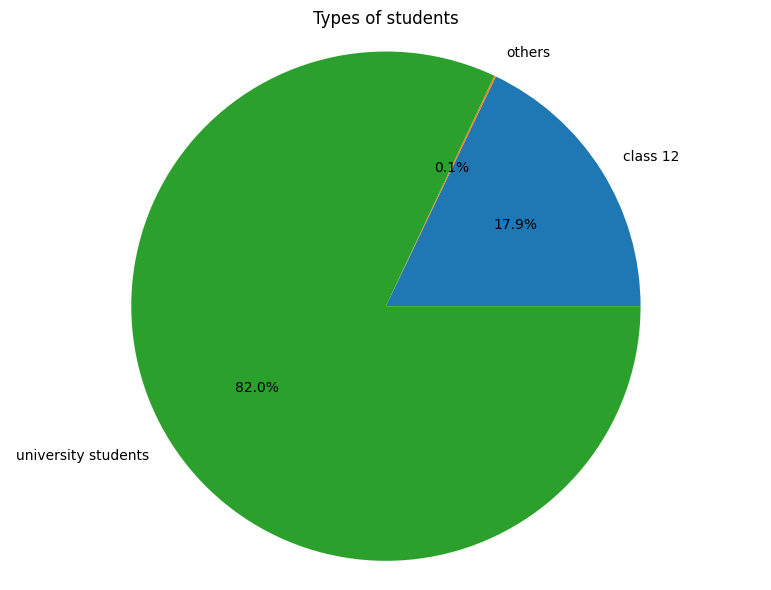

In [ ]:
value_counts = df["degree"].value_counts()

class_12_count = value_counts.get("'Class 12'", 0)
others_count = value_counts.get('Others', 0)
university_students_count = value_counts.drop(['Class 12', 'Others'], errors='ignore').sum()

pie_data = pd.Series([class_12_count, others_count, university_students_count], index=['class 12', 'others', 'university students'])

plt.figure(figsize=(8, 6))
plt.pie(pie_data, labels=pie_data.index, autopct='%1.1f%%')
plt.title('Types of students')
plt.axis('equal')
plt.tight_layout()
plt.show()

/tmp/ipython-input-10-278430105.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cgpa_depr = df.groupby("CGPA_bin")["depression"].mean()


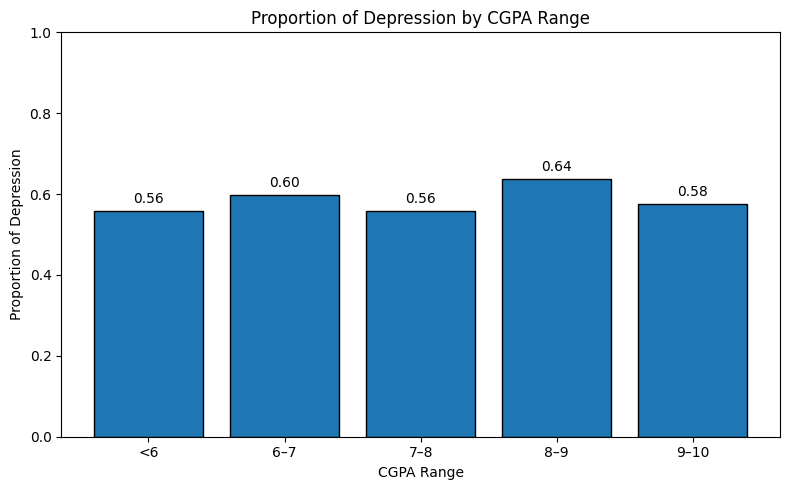

In [ ]:
bins = [0, 6, 7, 8, 9, 10]
labels = ["<6", "6–7", "7–8", "8–9", "9–10"]
df["CGPA_bin"] = pd.cut(
    df["cgpa"], bins=bins, labels=labels, include_lowest=True
)

cgpa_depr = df.groupby("CGPA_bin")["depression"].mean()

plt.figure(figsize=(8, 5))
plt.bar(cgpa_depr.index.astype(str), cgpa_depr.values, edgecolor="k")
plt.title("Proportion of Depression by CGPA Range")
plt.xlabel("CGPA Range")
plt.ylabel("Proportion of Depression")
plt.ylim(0, 1)


for x, y in zip(cgpa_depr.index.astype(str), cgpa_depr.values):
    plt.text(x, y + 0.02, f"{y:.2f}", ha="center")

plt.tight_layout()
plt.show()


**CGPA Range – Proportion Depressed**

Grades alone don't seem to have a big effect on the proportion of drepression.

Even top-performers with GPAs 9–10 still show ~58 % depression prevalence.

/tmp/ipython-input-11-3478061799.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([gpa_undep, gpa_dep],


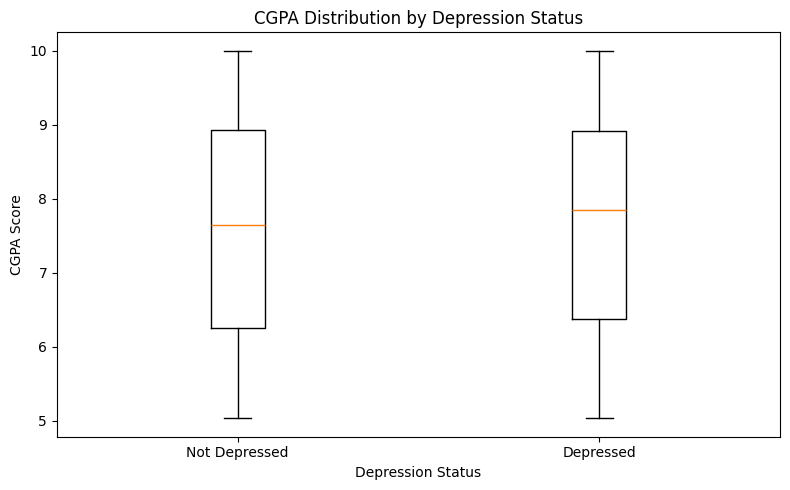

In [ ]:
gpa_undep = df[df["depression"] == 0]["cgpa"].dropna()
gpa_dep   = df[df["depression"] == 1]["cgpa"].dropna()


plt.figure(figsize=(8, 5))
plt.boxplot([gpa_undep, gpa_dep],
            labels=["Not Depressed", "Depressed"],
                showfliers=False
)
plt.title("CGPA Distribution by Depression Status")
plt.xlabel("Depression Status")
plt.ylabel("CGPA Score")
plt.tight_layout()
plt.show()


**CGPA Boxplot Split by Depression**


The median CGPA scores of both groups are very close to each other (both ~7.7).

The similarity between both boxplots could indicate that CGPA scores do not have a significant effect on depression among students.

CGPA scores don't seem promising enough for further analysis.

# Question 1: The strongest correlation

In [ ]:
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns

corr_with_dep = (
    df[numeric_cols]
      .corr(method="pearson")["depression"]
      .drop("depression")
      .sort_values(ascending=False)
)

print("\n=== Pearson correlation with Depression ===")
print(corr_with_dep)



=== Pearson correlation with Depression ===
suicidal_thoughts     0.546290
academic_pressure     0.474793
financial_stress      0.363591
study_hours           0.208627
family_history        0.053554
cgpa                  0.022268
study_satisfaction   -0.168010
age                  -0.226511
Name: depression, dtype: float64


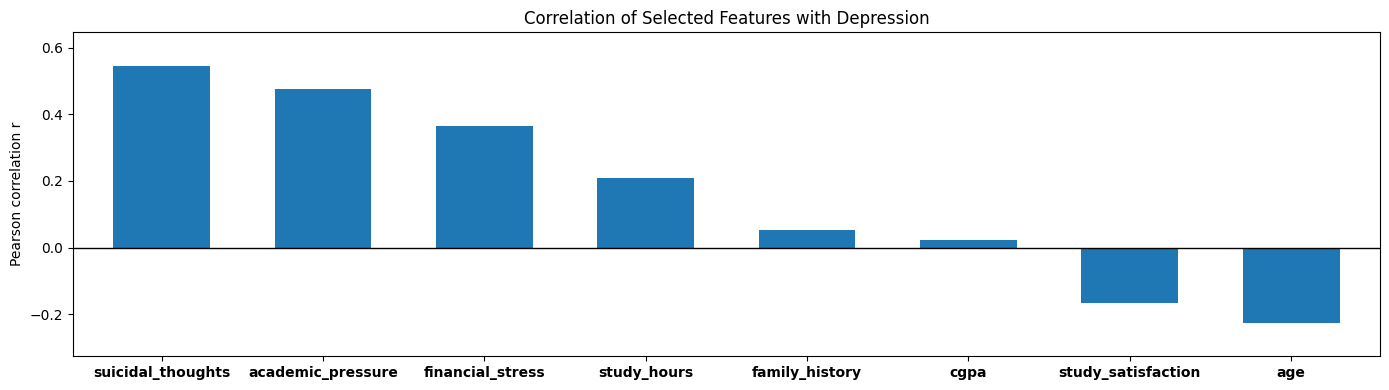

In [ ]:
cols = ["academic_pressure", "cgpa", "study_satisfaction",
        "study_hours", "financial_stress", "age",
        "suicidal_thoughts", "family_history"]

corr = (df[cols + ["depression"]]
          .corr(method="pearson")
          ["depression"]
          .drop("depression")
          .sort_values(ascending=False))


plt.figure(figsize=(14, 4))
corr.plot(kind="bar", width=0.6)
plt.axhline(0, color="black", linewidth=1)
plt.title("Correlation of Selected Features with Depression")
plt.ylim(min(corr-0.1),max(corr+0.1))

plt.ylabel("Pearson correlation r")
plt.xticks(rotation=0, fontweight="bold")
plt.tight_layout()
plt.show()


**Correlation between depression and various features**

Positive:
*   Suicidal thoughts tops the chart at r ≈ 0.55.
*   Academic pressure follows at r ≈ 0.47
*   Financial stress at r ≈ 0.36.
*   study hours at r ≈ 0.20

Barely:
*   Family history of mental illness at r ≈ 0.05
*   CGPA at r ≈ 0.02

Negative:
*   study satisfaction at r ≈ –0.18
*   age at r ≈ –0.24




From all of the categories, suicidal thoughts has the strongest (positive and absolute) correlation with depression.

 We want to look further into this category: Are depressed students more likely to have suicidal thoughts than non-depressed students?

In [ ]:
st_depression = df.copy()
st_depression["depression"] = st_depression["depression"].map({0: "Not Depressed", 1: "Depressed"})
st_depression = st_depression[["suicidal_thoughts", "depression"]]
depression = st_depression[st_depression["depression"] == "Depressed"]
no_depression = st_depression[st_depression["depression"] == "Not Depressed"]
depression_mean = np.mean(depression["suicidal_thoughts"])
no_depression_mean = np.mean(no_depression["suicidal_thoughts"])
print("On average, ", np.round(no_depression_mean*100, 2), "% of students who are not depressed had suicidal thoughts.")
print("On average, ", np.round(depression_mean*100, 2), "% of students who are depressed had suicidal thoughts.")

On average,  31.99 % of students who are not depressed had suicidal thoughts.
On average,  85.44 % of students who are depressed had suicidal thoughts.


In [ ]:
depression_only_st = depression["suicidal_thoughts"]
no_depression_only_st = no_depression["suicidal_thoughts"]

print("Suicidal thoughts standard deviation of students with no depression: ", np.std(no_depression_only_st))
print("Suicidal thoughts standard deviation of students with depression: ", np.std(depression_only_st))
stat, p_value = levene(depression_only_st, no_depression_only_st)
print("Levene's test statistic: ", stat)
print("p-value: ", p_value)

Suicidal thoughts standard deviation of students with no depression:  0.46643742853773285
Suicidal thoughts standard deviation of students with depression:  0.35268161884297855
Levene's test statistic:  1262.0973004393397
p-value:  2.0820964517422708e-270


Homoscedasticity is not given due to the very small p-value. Because of this, we will do a Mann-Whitney U test instead of a normal t-test. While the t-test tests a null hypothesis of two equal group means, the Mann-Whitney U test tests a null hypothesis whether randomly selected values from the two groups have the same probability distribution. We hypothesize that students who are depressed are more likely to have suicidal thoughts than students who are not depressed.
Therefore, our null hypothesis is: There's no difference between the distribution of suicidal thoughts of depressed students and non-depressed students. We'll define the significance level as 0.05 for the test.

In [ ]:
u_stat, p_value = mannwhitneyu(depression_only_st, no_depression_only_st, alternative='greater')
print("Based on the Mann–Whitney U statistic: ", u_stat, "and its p-value: ", p_value, ", we reject the null hypothesis and conclude that the values of the distribution of suicidal thoughts tends to be higher on depressed students than on non-depressed students.")

Based on the Mann–Whitney U statistic:  144921615.5 and its p-value:  0.0 , we reject the null hypothesis and conclude that the values of the distribution of suicidal thoughts tends to be higher on depressed students than on non-depressed students.


# Question 2: Academic pressure

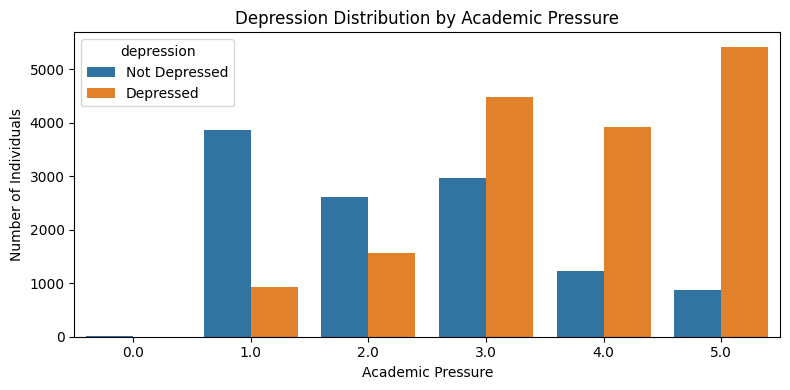

In [ ]:
ap_depression = df.copy()
ap_depression["depression"] = ap_depression["depression"].map({0: "Not Depressed", 1: "Depressed"})
ap_depression = ap_depression[["academic_pressure", "depression"]]
ap_depression_count = ap_depression.groupby(["academic_pressure", "depression"]).size().reset_index(name="count")

plt.figure(figsize=(8, 4))
sns.barplot(data=ap_depression_count, x="academic_pressure", y="count", hue="depression", hue_order=['Not Depressed', 'Depressed'])
plt.title("Depression Distribution by Academic Pressure")
plt.xlabel("Academic Pressure")
plt.ylabel("Number of Individuals")
plt.tight_layout()
plt.show()

Looking at the graph above, we see that for academic pressure >2, there are a lot more depressed students than non-depressed. Are students with depression more likely to have higher academic pressure than students with no depression?

In [ ]:
depression = ap_depression[ap_depression["depression"] == "Depressed"]
no_depression = ap_depression[ap_depression["depression"] == "Not Depressed"]
depression_mean = np.mean(depression["academic_pressure"])
no_depression_mean = np.mean(no_depression["academic_pressure"])
print("Academic pressure mean of students with no depression: ", no_depression_mean)
print("Academic pressure mean of students with depression: ", depression_mean)

Academic pressure mean of students with no depression:  2.3617573294127823
Academic pressure mean of students with depression:  3.6931741659014388


In [ ]:
depression_only_ap = depression["academic_pressure"]
no_depression_only_ap = no_depression["academic_pressure"]

print("Academic pressure standard deviation of students with no depression: ", np.std(no_depression_only_ap))
print("Academic pressure standard deviation of students with depression: ", np.std(depression_only_ap))
stat, p_value = levene(depression_only_ap, no_depression_only_ap)
print("Levene's test statistic: ", stat)
print("p-value: ", p_value)

Academic pressure standard deviation of students with no depression:  1.2529225228700138
Academic pressure standard deviation of students with depression:  1.1888212330114072
Levene's test statistic:  43.91367749277364
p-value:  3.494304944488987e-11


Homoscedasticity is not given due to the very small p-value. Because of this, we will do a Mann-Whitney U test instead of a normal t-test. We hypothesize that students who are depressed are more likely to have a higher academic pressure than students who are not depressed.
Therefore, our null hypothesis is: There's no difference between the distribution of academic pressure of depressed students and non-depressed students. We'll define the significance level as 0.05 for the test.



In [ ]:
u_stat, p_value = mannwhitneyu(depression_only_ap, no_depression_only_ap, alternative='greater')
print("Based on the Mann–Whitney U statistic: ", u_stat, "and its p-value: ", p_value, ", we reject the null hypothesis and conclude that the values of the distribution of academic pressure tends to be higher on depressed students than on non-depressed students.")

Based on the Mann–Whitney U statistic:  145518393.0 and its p-value:  0.0 , we reject the null hypothesis and conclude that the values of the distribution of academic pressure tends to be higher on depressed students than on non-depressed students.


# Classification

# kNN Classifier

In [ ]:
df_copy = df.copy()

# dropping rows with academic pressure = 0 because there are only 9 datapoints with a score of 0, it makes the plots nicer and works better with financial stress which only has values 1-5.
df_copy.drop(df[df["academic_pressure"]==0].index, inplace=True)
df_copy.reset_index(drop=True, inplace=True)

<Figure size 640x480 with 0 Axes>

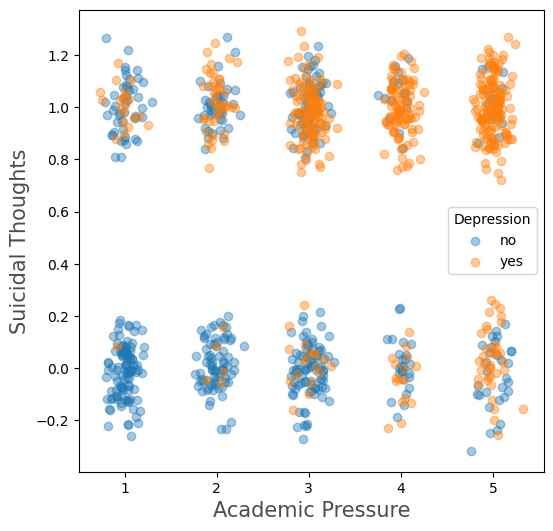

In [ ]:
groups = df_copy.groupby('depression')

plt.clf()
fig = plt.figure(figsize=(6, 6), dpi= 100, facecolor='w', edgecolor='k')
plot = fig.add_subplot(111, polar=False)
for name, group in groups:
  group_reset = group.reset_index(drop=True)
  jittered_x = group_reset.academic_pressure + np.random.normal(0, 0.1, size=group_reset.academic_pressure.shape)
  jittered_y = group_reset.suicidal_thoughts + np.random.normal(0, 0.1, size=group_reset.suicidal_thoughts.shape)
  sample_indices = np.random.choice(len(jittered_x), size=500, replace=False)
  sample_indicesy = np.random.choice(len(jittered_y), size=500, replace=False)
  plot.scatter(jittered_x[sample_indices], jittered_y[sample_indicesy], label=['no','yes'][name], alpha=0.4)
plot.legend(title="Depression")
plot.set_xlabel("Academic Pressure", alpha=0.7, size=15)
plot.set_ylabel("Suicidal Thoughts", alpha=0.7, size=15)
plt.show()

<Figure size 640x480 with 0 Axes>

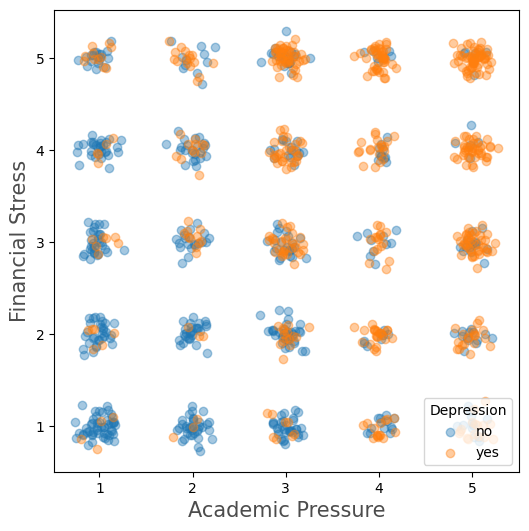

In [ ]:
groups = df_copy.groupby('depression')


plt.clf()
fig = plt.figure(figsize=(6, 6), dpi= 100, facecolor='w', edgecolor='k')
plot = fig.add_subplot(111, polar=False)
for name, group in groups:
  group_reset = group.reset_index(drop=True)
  jittered_x = group_reset.academic_pressure + np.random.normal(0, 0.1, size=group_reset.academic_pressure.shape)
  jittered_y = group_reset.financial_stress + np.random.normal(0, 0.1, size=group_reset.financial_stress.shape)
  sample_indices = np.random.choice(len(jittered_x), size=500, replace=False)
  sample_indicesy = np.random.choice(len(jittered_y), size=500, replace=False)
  plot.scatter(jittered_x[sample_indices], jittered_y[sample_indicesy], label=['no','yes'][name], alpha=0.4)
plot.legend(title="Depression")
plot.set_xlabel("Academic Pressure", alpha=0.7, size=15)
plot.set_ylabel("Financial Stress", alpha=0.7, size=15)
plt.show()

In [ ]:
X = df_copy[["academic_pressure", "financial_stress"]]
y = df_copy["depression"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

accuracies1 = []
for n in range(1,30):
  # Create a kNN classifier
  knn = KNeighborsClassifier(n_neighbors=n)

  # Fit the model on the training data
  knn.fit(X_train, y_train)

  # Make predictions on the test data
  predictions = knn.predict(X_test)

  # Calculate the accuracy
  accuracy = np.mean(y_test == predictions)
  accuracies1.append(accuracy)


In [ ]:
X = df_copy[["academic_pressure", "suicidal_thoughts"]]
y = df_copy["depression"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

accuracies2 = []
for n in range(1,30):
  # Create a kNN classifier
  knn = KNeighborsClassifier(n_neighbors=n)

  # Fit the model on the training data
  knn.fit(X_train, y_train)

  # Make predictions on the test data
  predictions = knn.predict(X_test)

  # Calculate the accuracy
  accuracy = np.mean(y_test == predictions)
  accuracies2.append(accuracy)


In [ ]:
X = df_copy[["academic_pressure"]]
y = df_copy["depression"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

accuracies4 = []
for n in range(1,30):
  # Create a kNN classifier
  knn = KNeighborsClassifier(n_neighbors=n)

  # Fit the model on the training data
  knn.fit(X_train, y_train)

  # Make predictions on the test data
  predictions = knn.predict(X_test)

  # Calculate the accuracy
  accuracy = np.mean(y_test == predictions)
  accuracies4.append(accuracy)

In [ ]:
X = df_copy[["academic_pressure", "suicidal_thoughts", "financial_stress"]]
y = df_copy["depression"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

accuracies3 = []
for n in range(1,30):
  # Create a kNN classifier
  knn = KNeighborsClassifier(n_neighbors=n)

  # Fit the model on the training data
  knn.fit(X_train, y_train)

  # Make predictions on the test data
  predictions = knn.predict(X_test)

  # Calculate the accuracy
  accuracy = np.mean(y_test == predictions)
  accuracies3.append(accuracy)

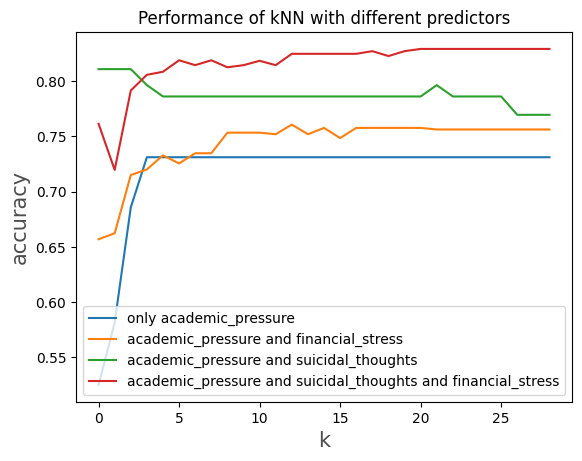

In [ ]:
plt.plot(accuracies4, label="only academic_pressure")
plt.plot(accuracies1, label="academic_pressure and financial_stress")
plt.plot(accuracies2, label="academic_pressure and suicidal_thoughts")
plt.plot(accuracies3, label="academic_pressure and suicidal_thoughts and financial_stress")

plt.xlabel("k", alpha=0.7, size=15)
plt.ylabel("accuracy", alpha=0.7, size=15)
plt.title("Performance of kNN with different predictors")
plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

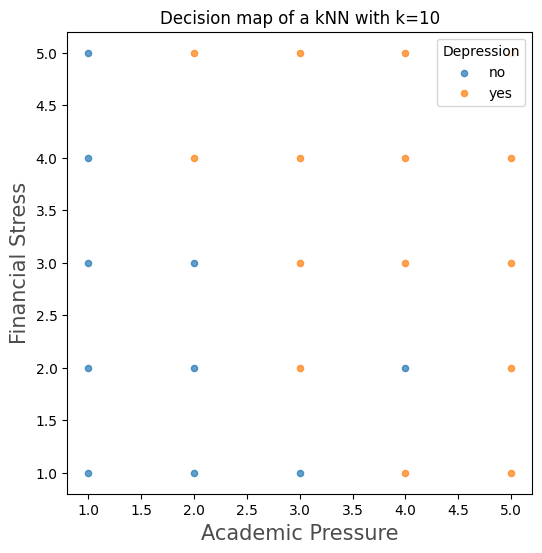

In [ ]:
X = df_copy[["academic_pressure", "financial_stress"]]
y = df_copy["depression"]

ap_range = np.arange(np.min(df_copy.academic_pressure), np.max(df_copy.academic_pressure)+1, 1)
st_range = np.arange(np.min(df_copy.financial_stress), np.max(df_copy.financial_stress)+1, 1)
grid = []
for i in ap_range:
    for j in st_range:
        grid.append([i, j])
grid = np.asarray(grid)
grid = pd.DataFrame(grid)
grid.rename(columns={0: "academic_pressure", 1: "financial_stress"}, inplace=True)

knn = KNeighborsClassifier(n_neighbors=10) # k=10
knn.fit(X, y)
predictions = knn.predict(grid)

grid["depression"] = predictions

groups2 = grid.groupby('depression')

plt.clf()
fig = plt.figure(figsize=(6, 6), dpi= 100, facecolor='w', edgecolor='k')
plot = fig.add_subplot(111, polar=False)
for name2, group2 in groups2:
    plot.scatter(group2.academic_pressure, group2.financial_stress, label=['no','yes'][name2], alpha=0.7, s=20)
plot.legend(title="Depression")
plot.set_xlabel("Academic Pressure", alpha=0.7, size=15)
plot.set_ylabel("Financial Stress", alpha=0.7, size=15)
plt.title("Decision map of a kNN with k=10")
plt.show()

# Bayes Classifier

<Figure size 640x480 with 0 Axes>

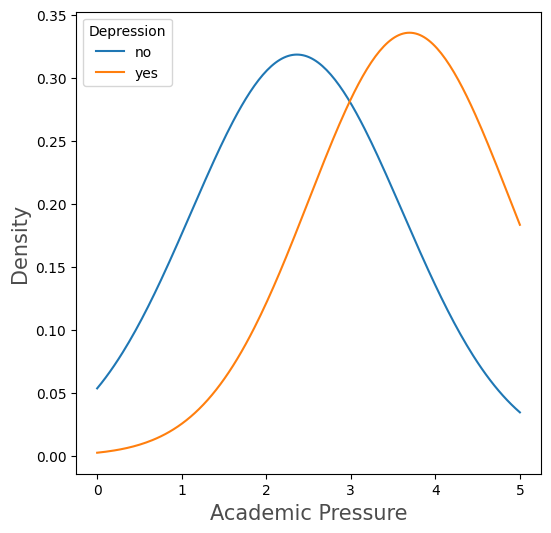

In [ ]:
groups = df_copy.groupby('depression')
xvals = np.linspace(0, np.max(df_copy.academic_pressure), 200)

plt.clf()
fig = plt.figure(figsize=(6, 6), dpi= 100, facecolor='w', edgecolor='k')
plot = fig.add_subplot(111, polar=False)
for name, group in groups:
    plt.plot(xvals, norm.pdf(xvals, np.mean(group.academic_pressure), np.std(group.academic_pressure)), label=["no", "yes"][name])
plot.legend(title="Depression")
plot.set_xlabel("Academic Pressure", alpha=0.7, size=15)
plot.set_ylabel("Density", alpha=0.7, size=15)
plt.show()

In [ ]:
means = {}
for name, group in groups:
    means[name]= [np.mean(group.academic_pressure), np.std(group.academic_pressure)]

likeliNo3 = norm.pdf(3, means[0][0], means[0][1])
likeliYes3 = norm.pdf(3, means[1][0], means[1][1])

print(likeliNo3, likeliYes3)

0.27989568857640335 0.283190573816832


In [ ]:
values, counts = np.unique(df_copy.depression.values, return_counts=True)

priorNo = counts[0]/np.sum(counts)
priorYes = counts[1]/np.sum(counts)

print(priorNo, priorYes)

0.4144286277743913 0.5855713722256086


In [ ]:
overNo3 = likeliNo3*priorNo
overYes3 = likeliYes3*priorYes

marginal3 = overNo3 + overYes3

posteriorNo3 = overNo3/marginal3
posteriorYes3 = overYes3/marginal3

print(posteriorNo3, posteriorYes3)

0.41159142588919273 0.5884085741108072


A student with an academic_pressure score of 3 would be classified as 'Yes' (Depression) by MLE and MAPE.

In [ ]:
def bayes_accuracy(newstudents:pd.DataFrame, oldstudents:pd.DataFrame):
    groups = oldstudents.groupby('depression')
    n = oldstudents.shape[0]

    params = {}
    for name, group in groups:
        params[name]= [np.mean(group.academic_pressure), np.std(group.academic_pressure), group.shape[0]/n]

    mle_predictions = []
    map_predictions = []
    for index in range(0, newstudents.shape[0]):
        likeli = []
        posteri = []
        namesls = []
        for name, group in groups:
            namesls.append(name)
            onelikeli = norm.pdf(newstudents.academic_pressure[index], params[name][0], params[name][1])
            likeli.append(onelikeli)
            posteri.append(onelikeli*params[name][2])
        ml = np.argmax(likeli)
        posteri = posteri/np.sum(posteri)
        mp = np.argmax(posteri)
        mle = namesls[ml]
        mape = namesls[mp]
        mle_predictions.append(mle)
        map_predictions.append(mape)
    newstudents = newstudents.assign(mle_pred = mle_predictions)
    newstudents = newstudents.assign(map_pred = map_predictions)
    mle_acc = np.mean(newstudents.mle_pred==newstudents.depression)
    map_acc = np.mean(newstudents.map_pred==newstudents.depression)
    return mle_acc, map_acc

In [ ]:
oldstudents = df_copy[["academic_pressure", "depression"]]

oldstudents = oldstudents.sample(frac=1).reset_index(drop=True)
twothirds = int(np.floor(oldstudents.shape[0]*0.66))
trainstudents = oldstudents.iloc[0:twothirds,:]
trainstudents.reset_index(inplace=True)
teststudents = oldstudents.iloc[twothirds:,:]
teststudents.reset_index(inplace=True)

mle_acc, map_acc = bayes_accuracy(newstudents=teststudents, oldstudents=trainstudents)
print("Accuracy using MLEs: "+str(mle_acc)+"\nAccuracy using MAPEs: "+ str(map_acc))

Accuracy using MLEs: 0.7315195613202573
Accuracy using MAPEs: 0.7315195613202573


MLE and MAPE give the same accuracy (close to the accuracy of kNN with only academic_pressure as a predictor and k=5).

Likely Causes:

-The priors are not different enough for them to influence the outcome.

-Academic Pressure is measured with few values and even at the value where the likelihood of both groups is very close (academic_pressure=3) it is classified the same using MLE and MAPE.

In [ ]:
def bayes_crossvalidation(allstudents:pd.DataFrame, slices:int):
    allstudents = allstudents.sample(frac=1).reset_index(drop=True)
    mle_accuracies = []
    map_accuracies = []
    testnum = int(np.floor(allstudents.shape[0]/slices))
    for i in range(slices):
        teststudents = allstudents.iloc[i:i+testnum,:].copy()
        teststudents.reset_index(inplace=True)
        trainstudents = allstudents.drop(labels=[j for j in range(i,i+testnum)], axis=0)
        trainstudents.reset_index(inplace=True)

        mle_acc, map_acc = bayes_accuracy(newstudents=teststudents, oldstudents=trainstudents)
        mle_accuracies.append(mle_acc)
        map_accuracies.append(map_acc)
    return np.mean(mle_accuracies), np.mean(map_accuracies)

In [ ]:
mle_acc, map_acc = bayes_crossvalidation(allstudents=oldstudents, slices=oldstudents.shape[0])
print("Cross-validated accuracy using MLEs: "+str(mle_acc)+"\nCross-validated accuracy using MAPEs: "+ str(map_acc))

Cross-validated accuracy using MLEs: 0.7283158234429344
Cross-validated accuracy using MAPEs: 0.7283158234429344


Because the MLE and MAPE are behaving the same in our case, the cv accuracy is also the same.

Academic pressure alone is a good predictor of depression among students but the accuracy can be improved by including financial stress or suicidal thoughts for the classification.